In [1]:
import pandas as pd

import reverse_geocoder as rg # Pour trouver la ville et le pays à partir des coordonnées géographiques

import re # Regex pour les expressions régulières

# Pour le traitement du texte
import nltk
from nltk.corpus import stopwords
import string

from wordcloud import WordCloud, ImageColorGenerator # Pour visualiser les nuages de mots

import numpy as np

import seaborn as sns # visualisation des données
import matplotlib.pyplot as plt 
%matplotlib inline



import warnings # Filtrer les warnings
warnings.filterwarnings("ignore")

# 1. Exploration des données

### 1.1 Visualisation et description statistique

In [2]:
# Charger les données
df = pd.read_csv(r'C:\Users\Sarah\Downloads\CVDesignR-ml-test-202006\data\data-jobs.csv')
df.head()

,id,contract_type,name,office_latitude,office_longitude,category_name
0,0,INTERNSHIP,[Louis Vuitton Germany] Praktikant (m/w) im Be...,48.139215,11.578141,Marketing / Communication
1,1,APPRENTICESHIP,[Christian Dior Couture] Alternance - Assistan...,48.866438,2.306873,Marketing / Communication
2,2,APPRENTICESHIP,Chargé (e) de Marketing Digital H/F (alternanc...,48.874676,2.290958,Marketing / Communication
3,3,INTERNSHIP,Bras Droit Marketing Manager,48.875369,2.337226,Marketing / Communication
4,4,INTERNSHIP,STAGE : CHARGE DE MARKETING INTERNATIONAL OPÉR...,48.874676,2.290958,Marketing / Communication


In [3]:
# Examiner la taille et les noms de colonnes
print("La taille de la base est:", df.shape)
print("Les colonnes sont:", df.columns)

La taille de la base est: (4749, 6)
Les colonnes sont: Index(['id', 'contract_type', 'name', 'office_latitude', 'office_longitude',
       'category_name'],
      dtype='object')


In [4]:
# Vérification des données manquantes
nans = df.shape[0] - df.dropna().shape[0]
print('{} rows have missing values'.format(nans))

0 rows have missing values


In [5]:
# Examiner les différents types de contrats et les différentes catégories  
print(df.contract_type.unique())
print(df.category_name.unique())

['INTERNSHIP' 'APPRENTICESHIP' 'FULL_TIME' 'TEMPORARY' 'VIE' 'FREELANCE'
 'PART_TIME']
['Marketing / Communication' 'Business' 'Retail' 'Administratif' 'Tech'
 'Design' 'Conseil']


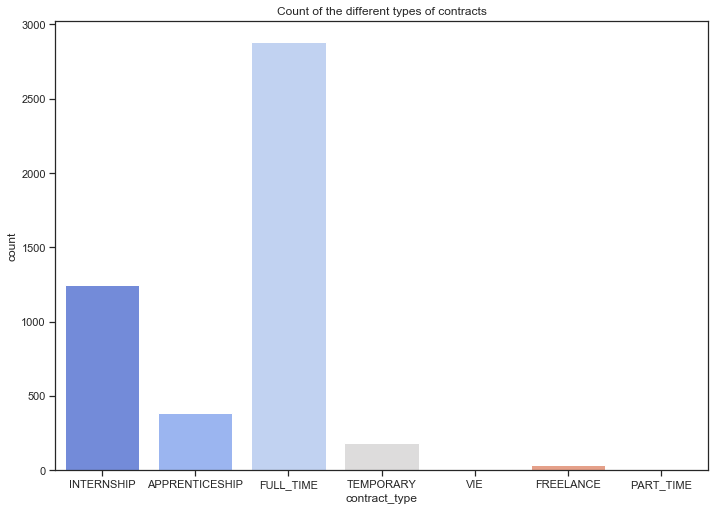

In [6]:
# Visualiser le nombre de contrats par type
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("ticks")
ax = sns.countplot(x=df["contract_type"], 
                   data=df, palette = sns.color_palette("coolwarm", 7)
                  ).set_title("Count of the different types of contracts")

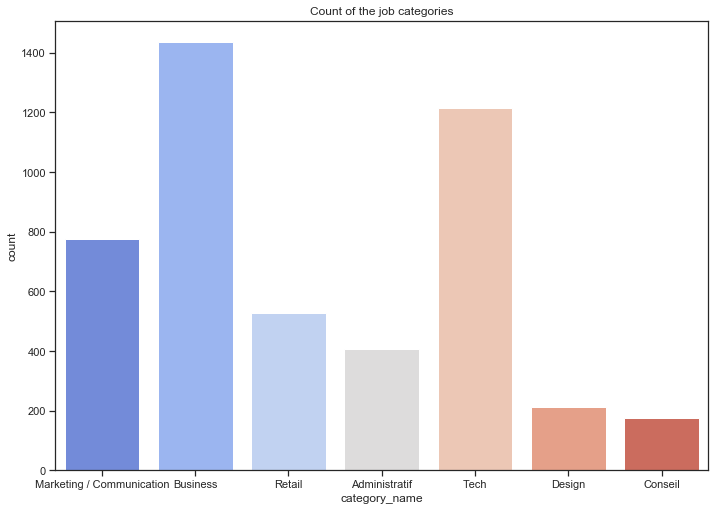

In [7]:
# Visualiser la distribution des catégories
ax = sns.countplot(x=df["category_name"], 
                   data=df, palette = sns.color_palette("coolwarm", 7)
                  ).set_title("Count of the job categories")

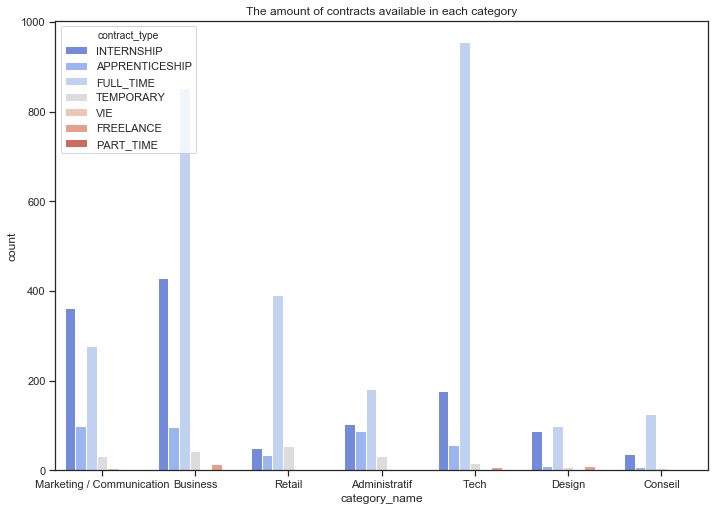

In [8]:
# Visualiser le nombre de contrat par type et par catégorie
ax = sns.countplot(x=df["category_name"], hue=df["contract_type"], 
                   data=df, palette = sns.color_palette("coolwarm", 7)
                  ).set_title("The amount of contracts available in each category")

### 1.2 Conclusions

* La base de données ne comporte pas des données manquantes
* Le type de contrat figurant le plus sur la base est: FULL_TIME
* Les top trois secteurs d'emploi sont: Business, Tech et Marketing/Communication 
* Le 3ème graphique montre que la majorité des contrats disponible en Business et en Tech sont des contrats FULL_TIME. Par contre pour le secteur du Marketing/Communication, la majorité des contrats sont des stages (INTERNSHIP)
* On dispose de 7 secteurs d'emploi et 7 types de contrats

# 2. Feature Engineering
## 2.1 Premières reflexions
* On a deux variables 'office_latitude' et 'office_longitude', pourquoi ne pas créer deux nouvelles variables City et Country?
* Nettoyage de la variable 'name':
        * Créer une nouvelle variable 'company' : Au niveau des crochets en prenant juste le texte entre '[]'  
        * On remarque que la variable 'name' contient du texte de différentes langues: (soit on ignore ce détail, soit on traite chaque texte dans sa langue)
        * Enlever la ponctuation, les STOPWORDS, mettre le texte en minuscule         
* D'après l'énoncé du problème, 'category_name' sont les labels

### Création des variables 'city' et 'country'

In [9]:
# Création des variables city et country_code
# Créer des couples de lattitude et de longitude
#df['coordinates'] = list(zip(df.office_latitude, df.office_longitude))

#df['city'] = ""
#df['country_code'] = ""

#for i in range(len(df.coordinates)):
 #  results = rg.search(df.coordinates.iloc[i])
 #  items = list(results[0].items())
 #  df.city.iloc[i] = items[2][1]
 #  df.country_code.iloc[i] = items[5][1]

df_geo = pd.read_csv(r'C:\Users\Sarah\Downloads\CVDesignR-ml-test-202006\data\data-jobs_cities_countries.csv')
df_geo = df_geo.drop('Unnamed: 10', 1)
df_geo = df_geo.drop('Unnamed: 11', 1)
df_geo = df_geo.drop('Unnamed: 9', 1)
df_geo

,id,contract_type,name,office_latitude,office_longitude,category_name,coordinates,city,country_code
0,0,INTERNSHIP,[Louis Vuitton Germany] Praktikant (m/w) im Be...,48.139215,11.578141,Marketing / Communication,"(48.1392154, 11.5781413)",Munich,DE
1,1,APPRENTICESHIP,[Christian Dior Couture] Alternance - Assistan...,48.866438,2.306873,Marketing / Communication,"(48.8664383, 2.3068732999999995)",Levallois-Perret,FR
2,2,APPRENTICESHIP,Chargé (e) de Marketing Digital H/F (alternanc...,48.874676,2.290958,Marketing / Communication,"(48.8746763, 2.2909585)",Levallois-Perret,FR
3,3,INTERNSHIP,Bras Droit Marketing Manager,48.875369,2.337226,Marketing / Communication,"(48.8753693, 2.3372256)",Paris,FR
4,4,INTERNSHIP,STAGE : CHARGE DE MARKETING INTERNATIONAL OPÉR...,48.874676,2.290958,Marketing / Communication,"(48.8746763, 2.2909585)",Levallois-Perret,FR
...,...,...,...,...,...,...,...,...,...
4744,4744,INTERNSHIP,Chargé de projets Architecture,48.872646,2.330584,Retail,"(48.87264620000001, 2.3305836)",Paris,FR
4745,4745,FULL_TIME,[LVMH Fragrance Brands France] Visual Merchand...,48.866104,2.305791,Retail,"(48.8661039, 2.305791)",Levallois-Perret,FR
4746,4746,FULL_TIME,PREPARATEUR (RICE) ECHANTILLONS PHOTO / STYLIS...,50.724823,3.163828,Retail,"(50.7248229, 3.1638275)",Tourcoing,FR
4747,4747,FULL_TIME,Responsable Commercial Export,48.890617,2.350303,Retail,"(48.8906175, 2.3503032000000004)",Saint-Ouen,FR


- L'exécution de cette étape prend beaucoup de temps, j'ai préféré la commenter mais j'ai exporté le nouveau fichier csv et vous le trouverez sous '~\CVDesignR-ml-test-202006\data\data-jobs_cities_countries.csv'
- Dans la suite je vais présenter quelques graphiques et des statistiques prenant en considération la position géographique mais je vais les enlever pour la suite des traitements.

###  Analyse de la distribution géographique des contrats à disposition

In [10]:
# Dans quel pays figure le plus grand nombre de contrats
value_count = df_geo['country_code'].value_counts()
value_count[:5]

FR    4289
US     147
GB      79
IT      29
DE      27
Name: country_code, dtype: int64

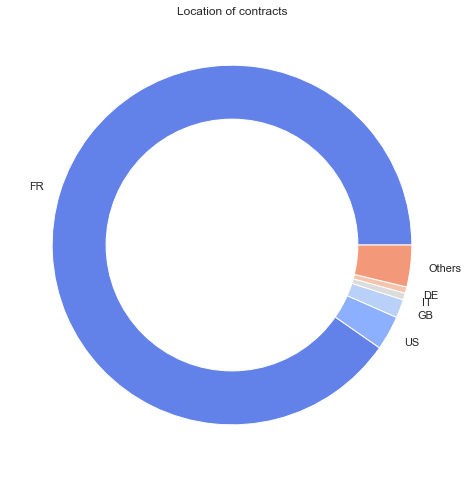

In [11]:
names='FR', 'US', 'GB', 'IT','DE','Others'
size=[4289,147,79,29,27, 178]

# Create a circle for the center of the plot

my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=sns.color_palette("coolwarm", 7))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Location of contracts')
plt.show()

In [12]:
# Quelles sont les 10 premières villes de France en offre d'emplois?
value_count = df_geo['city'].value_counts()
value_count[:10]

Paris                   1475
Levallois-Perret         667
Saint-Ouen               348
Clichy                   215
Neuilly-sur-Seine         95
Vanves                    93
Nanterre                  82
Aubervilliers             74
Issy-les-Moulineaux       66
Boulogne-Billancourt      57
Name: city, dtype: int64

- On remarque que la majorité des offres existent en Frances.
- Les 10 villes de France avec le maximum nombre d'offres d'emploi existent toutes en Région Parisienne.
- On pourra comme extension de ce travail pousser l'analyse en prenant en considération les nouvelles informations géographiques.

## 2.2 Nettoyage de la variable 'name' 

In [13]:
df = df.drop('office_latitude', 1)
df = df.drop('office_longitude', 1)

In [14]:
df.head()

,id,contract_type,name,category_name
0,0,INTERNSHIP,[Louis Vuitton Germany] Praktikant (m/w) im Be...,Marketing / Communication
1,1,APPRENTICESHIP,[Christian Dior Couture] Alternance - Assistan...,Marketing / Communication
2,2,APPRENTICESHIP,Chargé (e) de Marketing Digital H/F (alternanc...,Marketing / Communication
3,3,INTERNSHIP,Bras Droit Marketing Manager,Marketing / Communication
4,4,INTERNSHIP,STAGE : CHARGE DE MARKETING INTERNATIONAL OPÉR...,Marketing / Communication


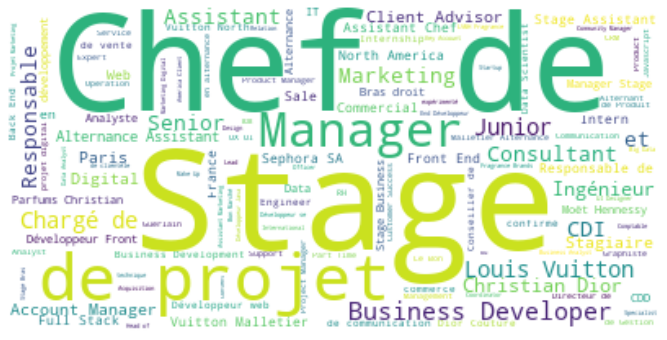

In [15]:
# Observons tout le texte écrit sous la variable 'name' et voyons les mots que se répétent le plus
texte1 = " ".join(text for text in df.name)
wordcloud_avant = WordCloud(background_color="white").generate(texte1)
plt.figure() 
plt.imshow(wordcloud_avant, interpolation='bilinear')
plt.axis("off")
plt.show()

- D'après cette figure on remarque que les intitulé de poste contiennent aussi les noms des entreprises et avec une fréquence élevée comme pour "Louis Vuitton" et "Christian Dior". Il y a aussi "de" et "et" qui sont récurrents.

- On va créer donc la variable 'company' comme discuté dans la partie 'Premières reflexions'

In [16]:
# Création de la variable 'company' à partir de 'name'
df['company']=""
for i in range(len(df.name)):
    m = re.search(r"\[.*?]", df.name.iloc[i])
    
    if m:
        df.company.iloc[i] = m.group(0)
        df.name.iloc[i] = re.sub(r"\[.*?]", '', df.name.iloc[i])
       
    else:
        df.company.iloc[i] = 'Null'

In [22]:
# Liste des STOPWORDs
STOPWORDS = stopwords.words('english') + stopwords.words('french') + stopwords.words('german'
                                                                                    ) + stopwords.words('italian') +['hf','fh']

In [23]:
# Nettoyage de 'name'
for i in range(len(df.name)):
    df.name.iloc[i] = df.name.iloc[i].lower() # Transformer en minuscule
    df.name.iloc[i] = re.sub(r'\d+', '', df.name.iloc[i]) # Enlever les chiffres
    df.name.iloc[i] = re.sub(r'[^\w\s]','',df.name.iloc[i]) # Enlever la ponctuation
    df.name.iloc[i] = re.sub("\s\s+" , "",df.name.iloc[i]) # Enlever l'espace en plus
    # Enlever les STOPWORDs
    sentence = df.name.iloc[i].split(" ")
    for word in list(sentence):
        if word in STOPWORDS:
            sentence.remove(word) 
        
        df.name.iloc[i]  = " ".join(sentence)
                

In [24]:
# Nettoyage de 'company'
for i in range(len(df.company)):
    df.company.iloc[i] = df.company.iloc[i].lower()
    df.company.iloc[i] = re.sub(r'\d+', '', df.company.iloc[i])
    df.company.iloc[i] = re.sub(r'[^\w\s]','',df.company.iloc[i])
    df.company.iloc[i] = re.sub("\s\s+" , "",df.company.iloc[i])
    sentence = df.company.iloc[i].split(" ")
    for word in list(sentence):
        if word in STOPWORDS:
            sentence.remove(word)  
        df.company.iloc[i]  = " ".join(sentence)
 

In [25]:
df.head()

,id,contract_type,name,category_name,company
0,0,INTERNSHIP,praktikant mw bereich digital retail ecommerce,Marketing / Communication,louis vuitton germany
1,1,APPRENTICESHIP,alternanceassistante développement communicat...,Marketing / Communication,christian dior couture
2,2,APPRENTICESHIP,chargé marketing digital alternance jj temps p...,Marketing / Communication,null
3,3,INTERNSHIP,bras droit marketing manager,Marketing / Communication,null
4,4,INTERNSHIP,stagecharge marketing international opérationnel,Marketing / Communication,null


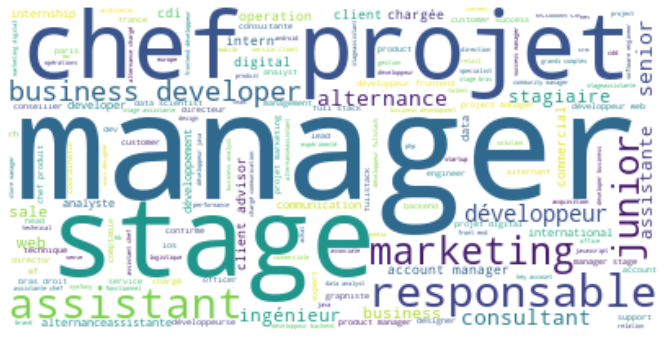

In [26]:
texte = " ".join(text for text in df.name)
wordcloud_apres = WordCloud(background_color="white").generate(texte)
plt.figure() 
plt.imshow(wordcloud_apres, interpolation='bilinear')
plt.axis("off")
plt.show()


In [27]:
# Les différentes entreprises qui recrutent.
# on a 3873 valeur manquantes
value_count = df['company'].value_counts()
value_count[1:11]

louis vuitton malletier        83
sephora                        77
louis vuitton north america    43
christian dior couture         41
bon marché                     32
guerlain                       25
parfums christian dior         24
fendi north america            21
celine                         20
lvmh fragrance brands          20
Name: company, dtype: int64

- Après la création de la variable 'company' de la variable 'name' et le nettoyage de cette dernière, j'ai crée un nouveau nuage de mots et on remarque que beaucoup de mots qui figuraient sur le premier nuage de mots ne figurent plus sur celui-là.
- Pour la variable 'company', on pourrait bien la nettoyer encore plus, enlever la position géographique puis changer le nom de la variable de 'company' à 'group' ou 'holding' et créer une nouvelle variable 'company' avec le nom de l'entreprise. Par exemple pour 'Christian Dior' on aura:
                    * 'group' --> 'Christian Dior'
                    * 'company' --> 'Parfums', 'Couture'
                   
# 3. Text-Mining


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [29]:
X = df.name
y = df.category_name
print(X.shape)
print(y.shape)

(4749,)
(4749,)


In [30]:
# Diviser les données ent test et train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3561,)
(1188,)
(3561,)
(1188,)


## 3.1 Naive Bayes Classifier

In [31]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)

In [32]:
test =['Directeur des ressources humaines']
y_pred = text_clf.predict(test)
print("La catégorie est:", y_pred)
print("L'accuracy est %.2f " %(accuracy*100) +'%')

La catégorie est: ['Administratif']
L'accuracy est 64.39 %


## 3.2 SVM Classifier

In [33]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)

In [34]:
test =['Directeur des ressources humaines']
y_pred = text_clf.predict(test)
print("La catégorie est:", y_pred)
print("L'accuracy est %.2f " %(accuracy*100) +'%')

La catégorie est: ['Administratif']
L'accuracy est 73.06 %


## 3.3 kNN Classifier

In [35]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=3)),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)

In [36]:
test =['Directeur des ressources humaines']
y_pred = text_clf.predict(test)
print("La catégorie est:", y_pred)
print("L'accuracy est %.2f " %(accuracy*100) +'%')

La catégorie est: ['Administratif']
L'accuracy est 68.27 %


## 3.4 Decision Tree Classifier

In [37]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)

In [38]:
test =['Directeur des ressources humaines']
y_pred = text_clf.predict(test)
print("La catégorie est:", y_pred)
print("L'accuracy est %.2f " %(accuracy*100) +'%')

La catégorie est: ['Administratif']
L'accuracy est 63.13 %


## 3.5 Random Forest Classifier

In [39]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=150)),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)

In [40]:
test =['Directeur des ressources humaines']
y_pred = text_clf.predict(test)
print("La catégorie est:", y_pred)
print("L'accuracy est %.2f " %(accuracy*100) +'%')

La catégorie est: ['Administratif']
L'accuracy est 67.76 %


## Résultats

- Les modèles que j'ai choisi pour explorer la base de données sont connus pour leur performance en classification des données vectorisées. Les cinq modèles ont bien prédit le test, mais le modèle plus performant est SVM.

- La classification avec SVM a donné une accuracy plus élévée que celle du Naive bayes parce qu'on a des données qui sont reliées entre elles et SVM respecte ce critère et ne traite pas les caractéristiques séparemment.

- On peut augmenter encore plus la performance de ces modèles et les comparer à nouveau en faisant de la cross-validation et en utilisant gridSearchCV de scikit-learn pour trouver la meilleure combinaison des paramètres.

- On peut aussi construire un modèle de Deep Learning avec des LSTMs ou des CNNs mais j'ai préféré testé une méthode de réduction de la dimensions et de visualisation des données en 2D qui est t-SNE

# 4. t-SNE

### 4.1 Motivations:

- Visualiser les données.
- Réduire les coûts de calcul, de stockage et d'acquisition des données.
- Améliorer la qualité des modèles d'apprentissage en se focalisant sur les variables pertinentes, en construisant des modèles moins complexes et enfin en réduisant le problème du fléau de ladimensionalité.

### 4.2 Etapes:

- Construire un corpus avec tous les mots du texte
- Transformer ces mots en vecteurs avec Word2Vec
- Projeter les données sur un plan
- Calculer les similarités entre certaines données


In [41]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [42]:
# Construire le corpus 

def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data.iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(X_train)  

In [43]:
# Transformer en Word2Vec
model = word2vec.Word2Vec(corpus)
model.wv['retail']

array([-0.00808919, -0.00231856,  0.00453304, -0.00534999, -0.01592462,
        0.00154291, -0.00350185, -0.00175515, -0.00378985,  0.02671161,
       -0.00658277,  0.01672816,  0.0160473 ,  0.01426867,  0.0138989 ,
        0.0095375 ,  0.02383939, -0.01176667,  0.00585395, -0.00081786,
       -0.0220783 ,  0.02597215, -0.02167444,  0.01401732,  0.00373675,
       -0.0485329 , -0.01126932, -0.03611538, -0.02806141,  0.01171247,
       -0.01035371, -0.01333931, -0.00801128, -0.00148536, -0.00901911,
        0.01266506, -0.0199003 , -0.01748985,  0.01124909,  0.00532211,
       -0.01470034,  0.01466052,  0.00464751, -0.03325611, -0.02302693,
        0.01382658,  0.00375173,  0.01346049,  0.00213288,  0.00859024,
        0.01930453,  0.00504301, -0.00922112, -0.03179701,  0.02628925,
       -0.00606612, -0.00684171, -0.01286991,  0.00924455, -0.00691228,
        0.01206933, -0.00093896,  0.01580095, -0.04300953,  0.00905582,
       -0.0126968 , -0.02431699,  0.02767826, -0.00286209,  0.01

In [44]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

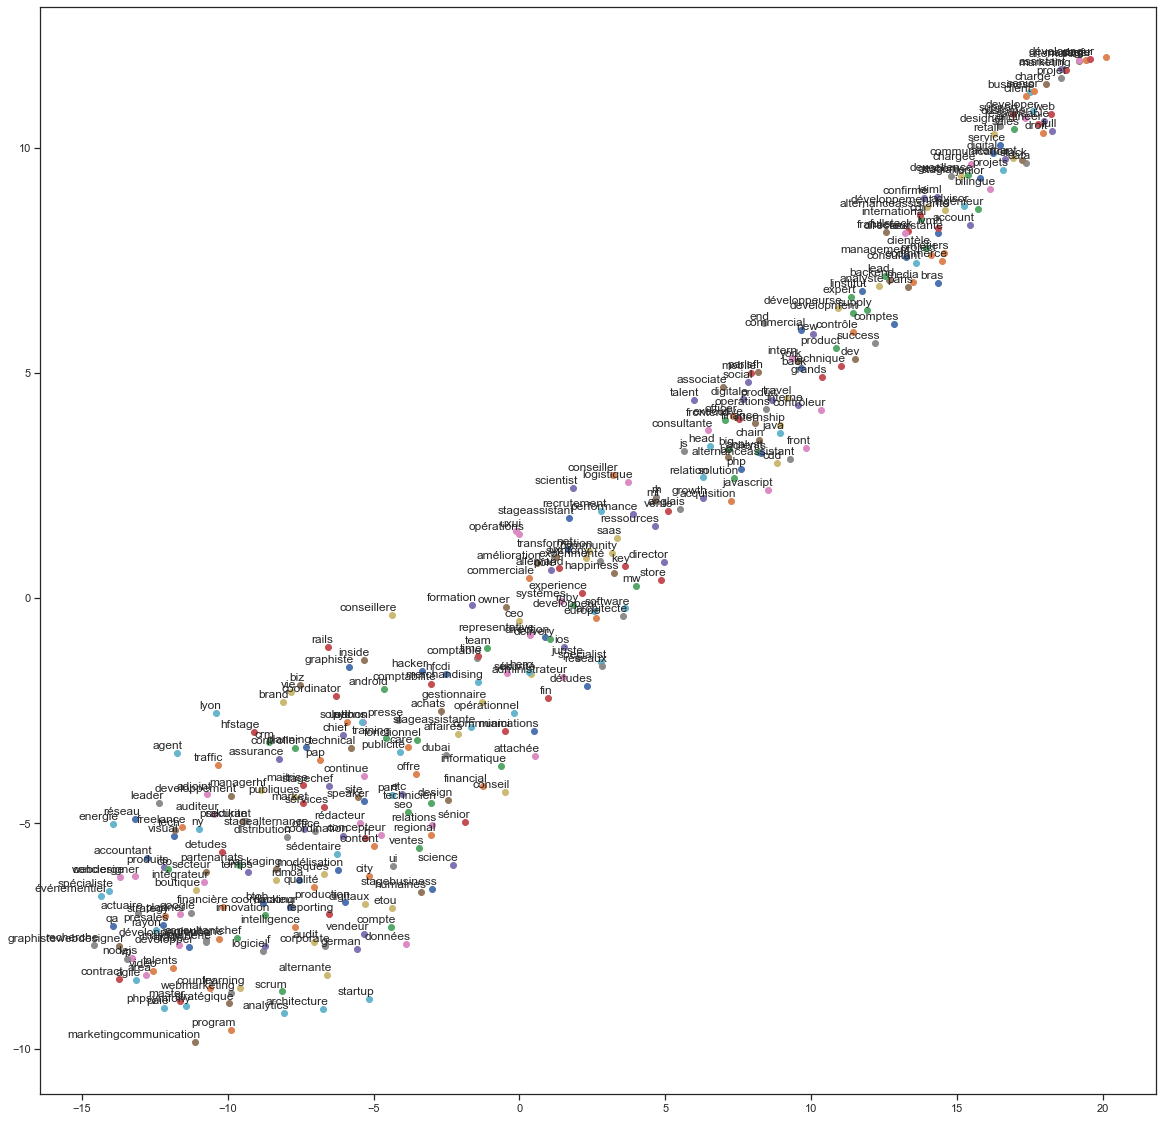

In [45]:
tsne_plot(model)

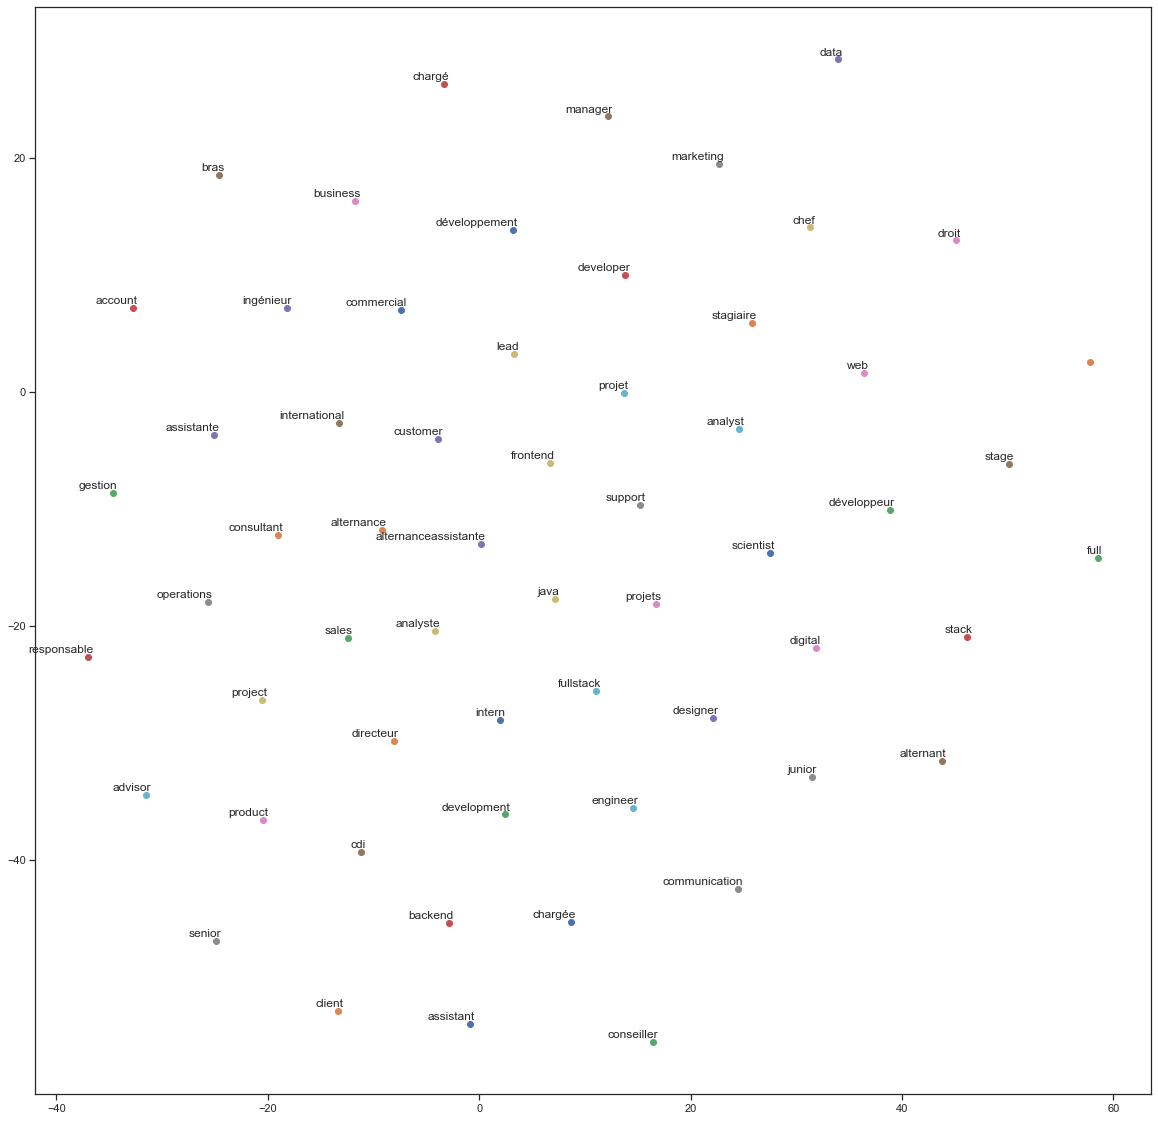

In [46]:
# On transforme le corpus en ignorant tous les mots avec une fréquence de moins de 30 
model_selectif = word2vec.Word2Vec(corpus, size=100, window=20,  min_count=30, workers=4)
tsne_plot(model_selectif)

In [47]:
model_selectif.most_similar('stage')

[('', 0.6658066511154175),
 ('full', 0.538114070892334),
 ('développeur', 0.4785967469215393),
 ('stack', 0.4554027020931244),
 ('marketing', 0.45282435417175293),
 ('data', 0.4461616277694702),
 ('junior', 0.3956994116306305),
 ('stagiaire', 0.3945380449295044),
 ('analyst', 0.36925244331359863),
 ('engineer', 0.36486563086509705)]

In [48]:
model.most_similar('stage')

[('', 0.9940743446350098),
 ('alternance', 0.9894728660583496),
 ('développeur', 0.9889193773269653),
 ('manager', 0.9867596626281738),
 ('projet', 0.9857585430145264),
 ('marketing', 0.9852739572525024),
 ('sales', 0.9842255115509033),
 ('assistant', 0.9840275645256042),
 ('chef', 0.983876645565033),
 ('customer', 0.9830652475357056)]

In [49]:
model_selectif.most_similar('ingénieur')

[('web', 0.40618419647216797),
 ('commercial', 0.37060636281967163),
 ('bras', 0.36343085765838623),
 ('manager', 0.32671844959259033),
 ('stage', 0.32152050733566284),
 ('data', 0.2734900116920471),
 ('projet', 0.2619636058807373),
 ('junior', 0.2574423849582672),
 ('', 0.2574000954627991),
 ('stack', 0.2547963559627533)]

In [50]:
model.most_similar('ingénieur')

[('', 0.9746270179748535),
 ('manager', 0.9742768406867981),
 ('stage', 0.9738133549690247),
 ('alternance', 0.9726142883300781),
 ('web', 0.9716446399688721),
 ('projet', 0.9702709913253784),
 ('développeur', 0.9696519374847412),
 ('customer', 0.969048261642456),
 ('chargé', 0.9686301350593567),
 ('chef', 0.9681298136711121)]

### 4.3 Conclusions

- Les similarités entre les modèles diffèrent si le word2vec est entrainé sur tout le corpus ou juste sur les mots les plus fréquents
- Le modèle selectif est plus sparse que le modèle entrainé sur tout le corpus.